# Generative Medical Image Segmentation

In [178]:
import numpy as np
import pandas as pd
import os

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split

# Remove grids
sns.set_style("dark")
plt.style.use("dark_background")

In [179]:
# --- LOAD DATA ---
data_path = "data/" # Path to the data folder

# Define image paths
data = []

for dir_ in os.listdir(data_path):
    dir_path = os.path.join(data_path, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"This is not an image folder: {dir_path}")


This is not an image folder: data/data.csv
This is not an image folder: data/README.md


In [180]:
# --- Create image and mask paths ---
df = pd.DataFrame(data, columns=["dir_name", "image_path"])

df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

imgs = sorted(df_imgs["image_path"].values, key = lambda x: int(x.split("_")[-1].split(".")[0]))
masks = sorted(df_masks["image_path"].values, key = lambda x: int(x.split("_")[-2]))

# --- Create final dataframe ---
df_final = pd.DataFrame()
df_final["image_path"] = imgs
df_final["mask_path"] = masks

# Create new column for diagnosis
def diagnosis(mask_path):
    """
    Function to determine the diagnosis based on the mask.
    If the mask is empty (all zeros), the diagnosis is 0.
    If the mask contains any non-zero values, the diagnosis is 1.
    """
    
    if np.max(cv2.imread(mask_path)) == 0:
        return 0
    else:
        return 1
    
df_final["diagnosis"] = df_final["mask_path"].apply(diagnosis)

In [251]:
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision.transforms as transforms
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 256
NUM_WORKERS = 0

In [182]:
# --- Define Dataset ---
class MRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        mask_path = self.df.iloc[idx]["mask_path"]

        # Read images with cv2
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Convert numpy arrays to PIL images
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transformation
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    #transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.5], std=[0.5])  
])


### Split Data into Training, Test Sets

In [ ]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df_final, test_size=0.1, random_state=42, stratify=df_final["diagnosis"])

# Create datasets
train_dataset = MRIDataset(train_df, transform=transforms)
val_dataset = MRIDataset(val_df, transform=transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 3536
Number of validation samples: 393


### Vizualize MRI images and Masks

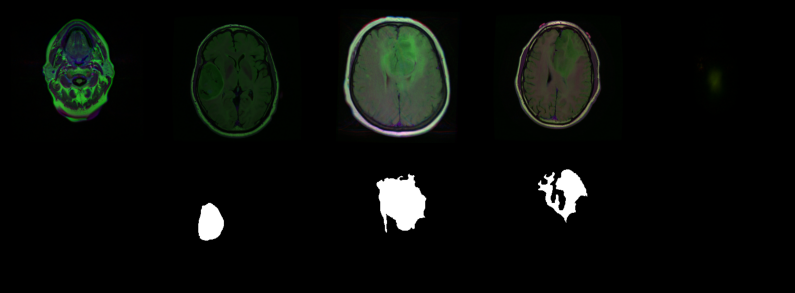

In [247]:
# --- Visualize some images and masks ---
def visualize_data(loader, num_images=5):
    images, masks = next(iter(loader))
    images = images.numpy()
    masks = masks.numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(10, 20))
    for i in range(num_images):
        axes[0, i].imshow(images[i].transpose(1, 2, 0))
        axes[0, i].axis("off")
        axes[1, i].imshow(masks[i].transpose(1, 2, 0))
        axes[1, i].axis("off")
    plt.subplots_adjust(hspace=-0.9)
    plt.show()

visualize_data(train_loader)

In [ ]:
# --- Define Encoder ---
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        self.input_dim = input_dim
        
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, self.input_dim)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale
    
# --- Define Decoder ---
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim, binary=False):
        self.binary = binary
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, output_dim)
        if not self.binary:
            self.fc22 = nn.Linear(hidden_dim, output_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x input_dim
        if self.binary:
            out = torch.sigmoid(self.fc21(hidden))
        else:
            out = (self.fc21(hidden), self.softplus(self.fc22(hidden)))
        return out